# Unsupervised classification of normal/anomalous sounds: embedding with FaceNet + triplet loss on machine types

To be executed on Google Colab, otherwise the computation time explodes.

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/gefleury/datascientest_anomalous_sounds/blob/main/notebooks/ASD_clf_sounds_FaceNet_machine.ipynb) 

In this version, the melspectrograms are stored in the folder `Features/melspec_313_128/`. Each machine has its folder `fan/`, `valve/` etc... and each audio sample has its own melspectrogram flattened stored as a .npy file. We use FaceNet to embed the melspectrograms into vectors of length 128. The embedding is done by using the triplet loss on the machine type. Then the embedding vectors are used to feed a Random Forest classifier that predicts the machine type. Sounds that are not well classified or are well classified but with a too low probability are then said to be anomalous.

## Import packages

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import seaborn as sns

from IPython.display import Image, display

from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, f1_score, accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, GlobalAveragePooling2D, MaxPooling2D, Flatten, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.utils import Sequence

import os



## Show the gpu infos 
... and change if needed in "Execution" panel

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Jul 19 16:44:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Import the spectrograms from Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/DATA_DCASE2022/Features.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')     # create a copy directly in colab for efficiency reasons

Mounted at /content/drive


In [ ]:
#Constants
#PATH_FEATURES_FOLDER = './Features/'
PATH_FEATURES_FOLDER = r"/content/Features/"
PATH_MELSPEC_313_128_FOLDER = PATH_FEATURES_FOLDER + 'melspec_313_128/'

## Build selection dataframe

The spectrogram are stored in the folder `Features/melspec_313_128/`. Each machinery has its folder `fan`, `valve/` etc... <br />
Each audio sample has its own mespectrogram flattened stored as a .npy file. So each file is one line of 313*128 = 40064 features.

We first build a dataframe df which gives us all the properties of the files. This will be used to select sounds according to their section, sound_type, etc ...

In [ ]:
def build_selection_dataframe(folder_path):
    list_dict_file = []    # list of dictionnaries for creating DataFrame

    for subdirectory, directory, files in os.walk(folder_path):
    
        #Get label using directory folder name
        label = subdirectory.split('/')[-1]
        
        #Loop through files
        for file in files:
            path_file = subdirectory + '/' + file
            splitted_filename = file.split('_')

            #Append dictionnary to list
            list_dict_file.append({
                'filepath' : path_file,
                'machine' : label,
                'section' : int(splitted_filename[1]),
                'domain_env' : splitted_filename[2],
                'dir' : splitted_filename[3],
                'sound_type' : splitted_filename[4],
                'id' : splitted_filename[5],
                'suffix' : '_'.join(splitted_filename[6:]).split('.npy')[0]  
            })

    return pd.DataFrame(list_dict_file)

In [ ]:
df = build_selection_dataframe(PATH_MELSPEC_313_128_FOLDER)

In [ ]:
#Encoding labels
df['sound_type'] = df['sound_type'].replace(['normal', 'anomaly'], [0, 1])


label_encoder = LabelEncoder()
df['machine_num'] = label_encoder.fit_transform(df['machine'])

dico = {}
for i in range(7):
    dico[label_encoder.inverse_transform([i])[0]] = i
df_machine = pd.DataFrame.from_dict(dico, orient = 'index', columns = ['machine_num'])

df_machine

,machine_num
ToyCar,0
ToyTrain,1
bearing,2
fan,3
gearbox,4
slider,5
valve,6


In [ ]:
df.head()

,filepath,machine,section,domain_env,dir,sound_type,id,suffix,machine_num
0,/content/Features/melspec_313_128/fan/section_...,fan,1,source,train,0,0704,f-n_B,3
1,/content/Features/melspec_313_128/fan/section_...,fan,1,source,train,0,0778,f-n_B,3
2,/content/Features/melspec_313_128/fan/section_...,fan,1,source,train,0,0316,f-n_A,3
3,/content/Features/melspec_313_128/fan/section_...,fan,0,source,train,0,0756,m-n_X,3
4,/content/Features/melspec_313_128/fan/section_...,fan,2,source,test,0,0040,n-lv_L1,3


In [ ]:
df['machine'].value_counts()

fan         3600
gearbox     3600
slider      3600
ToyCar      3600
ToyTrain    3600
valve       3600
bearing     3599
Name: machine, dtype: int64

## Prepare the train, valid, test datasets

In [ ]:
# Choose data
# We take only data from the source domain
#train_df = df[(df['dir']=='train') & (df['domain_env']=='source')]     
#test_df = df[(df['dir']=='test') & (df['domain_env']=='source')]      
# We take data from the source and target domains
train_df = df[df['dir']=='train'].groupby('machine').sample(n = 1000, random_state = 1)     
test_df = df[df['dir']=='test']     

train_filepaths = train_df['filepath']             
#test_filepaths = test_df['filepath'] 

train_labels = train_df['machine_num']       
#test_labels = test_df['machine_num']

# Separate the train set into train and validation sets
train_filepaths, valid_filepaths, y_train, y_valid = train_test_split(train_filepaths, \
                                                                        train_labels, test_size=0.2, \
                                                                        stratify = train_labels)


valid_df = train_df[train_df['filepath'].isin(valid_filepaths)]  # before the next line (redefinition of train_df)
train_df = train_df[train_df['filepath'].isin(train_filepaths)]

train_df.head(2)

,filepath,machine,section,domain_env,dir,sound_type,id,suffix,machine_num
16765,/content/Features/melspec_313_128/ToyCar/secti...,ToyCar,2,source,train,0,0916,car_A2_spd_40V_mic_1_noise_1,0
16095,/content/Features/melspec_313_128/ToyCar/secti...,ToyCar,1,source,train,0,0320,car_A1_spd_40V_mic_1_noise_1,0


Group the melspectrograms per machine

In [ ]:
data_train = train_df.groupby('machine_num').agg({'filepath': list, 'section': list, \
                                              'domain_env': list, 'dir': lambda x: x.unique(), \
                                              'sound_type': list, 'id': list, 'suffix': list, \
                                              'machine': lambda x: x.unique()}).reset_index()

data_valid = valid_df.groupby('machine_num').agg({'filepath': list, 'section': list, \
                                              'domain_env': list, 'dir': lambda x: x.unique(), \
                                              'sound_type': list, 'id': list, 'suffix': list, \
                                              'machine': lambda x: x.unique()}).reset_index()


data_train
#print(data_train.loc[0, 'domain_env'].count('target'))
#print(data_train.loc[0, 'domain_env'].count('source'))

,machine_num,filepath,section,domain_env,dir,sound_type,id,suffix,machine
0,0,[/content/Features/melspec_313_128/ToyCar/sect...,"[2, 1, 2, 0, 2, 0, 2, 0, 1, 1, 0, 1, 0, 2, 2, ...","[source, source, source, source, source, sourc...",train,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0916, 0320, 0648, 0386, 0409, 0754, 0142, 063...","[car_A2_spd_40V_mic_1_noise_1, car_A1_spd_40V_...",ToyCar
1,1,[/content/Features/melspec_313_128/ToyTrain/se...,"[0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 2, 0, 1, ...","[source, source, source, source, source, sourc...",train,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0509, 0978, 0252, 0105, 0813, 0123, 0829, 091...","[car_E1_spd_6_mic_1_noise_1, car_A2_spd_10_mic...",ToyTrain
2,2,[/content/Features/melspec_313_128/bearing/sec...,"[2, 0, 0, 0, 2, 1, 0, 2, 0, 0, 2, 0, 0, 1, 1, ...","[source, source, source, source, source, sourc...",train,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0428, 0252, 0758, 0046, 0614, 0623, 0056, 077...","[vel_14_f-n_B, vel_6, vel_22, vel_22, vel_6_f-...",bearing
3,3,[/content/Features/melspec_313_128/fan/section...,"[0, 2, 1, 1, 2, 2, 1, 0, 0, 2, 1, 0, 1, 0, 1, ...","[source, source, source, source, source, sourc...",train,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0145, 0156, 0713, 0873, 0018, 0579, 0610, 080...","[m-n_W, n-lv_L1, f-n_A, f-n_B, n-lv_L2, n-lv_L...",fan
4,4,[/content/Features/melspec_313_128/gearbox/sec...,"[0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 2, 2, 2, 1, 0, ...","[source, source, source, source, source, sourc...",train,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0542, 0066, 0732, 0089, 0194, 0298, 0816, 074...","[volt_2.0, volt_2.0, volt_1.5, volt_2.5, volt_...",gearbox
5,5,[/content/Features/melspec_313_128/slider/sect...,"[1, 0, 1, 0, 1, 2, 2, 0, 2, 1, 1, 2, 1, 1, 2, ...","[source, source, source, source, source, sourc...",train,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0341, 0167, 0375, 0293, 0880, 0745, 0526, 063...","[ac_0.07, vel_300, ac_0.11, vel_1100, ac_0.03,...",slider
6,6,[/content/Features/melspec_313_128/valve/secti...,"[0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 1, 2, 0, 0, 1, ...","[source, source, source, source, source, sourc...",train,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0344, 0898, 0358, 0350, 0306, 0870, 0172, 084...","[pat_00, pat_01, pat_01, v1pat_04, v1pat_04, v...",valve


## Define the generator

In the FaceNet approach, each batch must be made of :  
- an anchor ie a random spectrogram 
- a "positive" spectrogram ie a random spectrogram with the same machine type than anchor
- a "negative" spectrogram ie a random spectrogram with another machine type than anchor and positive

First, define a function to load and normalize the melspectrograms (the method is a bit weird since each spectrogram is mapped to a RBG image with 3 channels instead of 1 originaly. I proceed that way to be sure the normalization is done properly and identically for each dataset).

In [ ]:
def load_spectro(filepath):
    
    # Load the original melspectogram array
    spectro_array = np.load(filepath).reshape(128, 313)
    # Convert it to a RGB image (there are probably better ways to do it)
    plt.imsave('spectro.png', spectro_array, cmap='magma')
    img = keras.preprocessing.image.load_img('spectro.png')
    # Convert it back to an array
    img = keras.preprocessing.image.img_to_array(img)
    # Normalize
    img = img / 255
    
    #print("img shape =", img.shape)

    return img

/content/Features/melspec_313_128/slider/section_02_source_test_anomaly_0008_f-n_B.npy


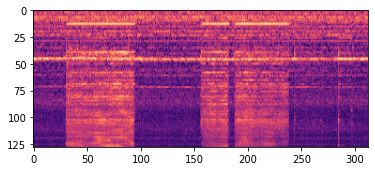

In [ ]:
# Test
my_spectro_path = df[df['machine']=='slider']['filepath'].sample(n = 1, random_state = 1).values[0]
print(my_spectro_path)

spectro_img = load_spectro(my_spectro_path)
plt.imshow(spectro_img, cmap = 'magma');

Load melspectrograms of each section into X_train, X_valid together with the section label into y_train, y_valid. X_train/X_valid is a list whose :
* First dimension corresponds to the different machine types (0,1,..,6)
* Second dimension corresponds to the melspectrograms of a given machine



In [ ]:
from tqdm import tqdm

# Shouldn't it be included in the generator?
def load_spectros_per_machine(data):
    X = []
    y = []

    for d in tqdm(data.values):
        mach_num, paths, secs, domains, dir, soundtypes, ids, sufs, mach = d
        X_machine = []
        #y_machine = []

        for i in range(len(paths)):
            im = load_spectro(paths[i])
            X_machine.append(im)
            #y_machine.append(mach_num)
            
        X.append(np.array(X_machine))
        #y.append(np.array(y_machine))
        y.append(mach_num)

    return X, y



In [ ]:
X_train, y_train = load_spectros_per_machine(data_train)
X_valid, y_valid = load_spectros_per_machine(data_valid)

100%|██████████| 7/7 [00:36<00:00,  5.25s/it]


In [ ]:
print(y_valid)

[0, 1, 2, 3, 4, 5, 6]


Define the batch generator

In [ ]:
import random

def generator(X, y, nb_sample, epochs=30, batch_size=32):
    machine_range = range(0, len(X))
    while(True):
        for i in range(0, nb_sample, batch_size):
            X_batch = []
            y_batch = []
            for j in range(0, batch_size):  
                # random choice of the anchor, positive and negative (see the FaceNet paper for more evolved process)  
                machine1, machine2 = random.sample(machine_range, 2)        
                mach1_img_1, mach1_img_2 = random.sample(range(len(X[machine1])), 2)    # mach1 -> 2 spectrograms
                mach2_img_1 = random.sample(range(len(X[machine2])), 1)[0]             # mach2 -> 1 spectrogram
                X_batch.extend([X[machine1][mach1_img_1], \
                                X[machine1][mach1_img_2], \
                                X[machine2][mach2_img_1]])
                y_batch.extend([y[machine1], y[machine1], y[machine2]])
            X_batch = np.array(X_batch)
            y_batch = np.array(y_batch)
            
            # In the course : Why we do not keep the information about the label?
            # Indeed, the label is not used in the loss function 
            #yield X_batch, np.zeros(len(X_batch))     
            yield X_batch, y_batch              # My modified version to keep y but to be checked
            


In [ ]:
batch_size = 32
gen_train = generator(X_train, y_train, epochs=10, batch_size = batch_size, nb_sample = len(train_filepaths))
gen_valid = generator(X_valid, y_valid, epochs=10, batch_size = batch_size, nb_sample = len(valid_filepaths))

Show a few triplets (test)

In [ ]:
X_t, y_t = next(gen_train)
X_t.shape, y_t.shape

((96, 128, 313, 3), (96,))

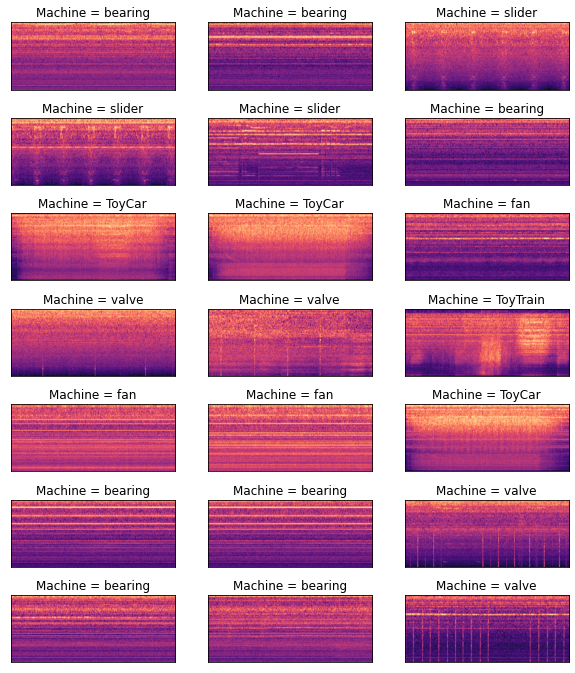

In [ ]:
plt.figure(figsize=(10,12))
for i in range(7):
    for j in range(3):
        plt.subplot(7,3,i*3 + j +1)
        plt.imshow(X_t[i*3+j])
        whichmachine = df_machine[df_machine['machine_num']==y_t[i*3+j]].index[0]
        plt.title("Machine = " + whichmachine)
        plt.xticks([])
        plt.yticks([])


## Model definition

In [ ]:
model = Sequential()

model.add(Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=[128, 313, 3]))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128))       # Embedding vector of length 128
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 313, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 156, 16)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 156, 32)       4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 78, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 78, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 39, 64)       0

Define the triplet loss function. For a triplet (anchor, positive, negative), the purpose is to get close embedding vectors of the anchor and the positive and distant embedding vectors of the anchor and the negative

In [ ]:
alpha = 0.2

def normL2(X1, X2):
    return tf.reduce_mean(tf.square(X1-X2), axis=-1)

def loss(y_true, y_pred):
    # L2 normalisation
    y_pred = y_pred / tf.expand_dims(tf.norm(y_pred, axis=-1),-1)
    p1_id1 = y_pred[::3]
    p1_id2 = y_pred[1::3]
    p2_id1 = y_pred[2::3]                                                                  
    return tf.reduce_mean(tf.nn.relu(normL2(p1_id1, p1_id2) - normL2(p1_id1, p2_id1) + alpha)) #100*

# Another loss function
def loss_2(y_true, y_pred):
    p1_id1 = y_pred[::3]
    p1_id2 = y_pred[1::3]
    p2_id1 = y_pred[2::3]
    return tf.reduce_mean(1/2*normL2(p1_id1, p1_id2)/(1e-8+1/4* normL2(p1_id1, p2_id1) + 1/4* normL2(p1_id2, p2_id1)))

Compile and fit

In [ ]:
model.compile(loss = loss_2, optimizer = 'adam')

steps_per_epoch = np.int32(np.ceil(len(train_filepaths)/batch_size))
validation_steps = np.int32(np.ceil(len(valid_filepaths)/batch_size))

early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 0.005, patience = 10, \
                               mode = 'min', restore_best_weights = True, verbose = 1)
reduce_learning_rate = ReduceLROnPlateau(monitor = 'val_loss', min_delta = 0.01, patience = 5, \
                                        factor = 0.3, cooldown = 4, verbose = 1)

training_history = model.fit(gen_train, validation_data = gen_valid, steps_per_epoch = steps_per_epoch,
        validation_steps = validation_steps, epochs = 50, callbacks = [early_stopping, reduce_learning_rate])

Epoch 1/50
175/175 [==============================] - 24s 65ms/step - loss: 0.5102 - val_loss: 0.2933 - lr: 0.0010
Epoch 2/50
175/175 [==============================] - 9s 53ms/step - loss: 0.3033 - val_loss: 0.2483 - lr: 0.0010
Epoch 3/50
175/175 [==============================] - 9s 53ms/step - loss: 0.2409 - val_loss: 0.1861 - lr: 0.0010
Epoch 4/50
175/175 [==============================] - 9s 53ms/step - loss: 0.2202 - val_loss: 0.1793 - lr: 0.0010
Epoch 5/50
175/175 [==============================] - 9s 54ms/step - loss: 0.1974 - val_loss: 0.1924 - lr: 0.0010
Epoch 6/50
175/175 [==============================] - 9s 53ms/step - loss: 0.1868 - val_loss: 0.1455 - lr: 0.0010
Epoch 7/50
175/175 [==============================] - 9s 52ms/step - loss: 0.1543 - val_loss: 0.1107 - lr: 0.0010
Epoch 8/50
175/175 [==============================] - 9s 54ms/step - loss: 0.1220 - val_loss: 0.0699 - lr: 0.0010
Epoch 9/50
175/175 [==============================] - 9s 53ms/step - loss: 0.0916 - val

In [ ]:
#Plot training
def plot_training_diag(history):
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(np.arange(1 , len(history.history['loss']) + 1, 1),
            history.history['loss'],
            label = 'Training loss',
            color = 'blue')
    plt.plot(np.arange(1 , len(history.history['val_loss']) + 1, 1),
            history.history['val_loss'], 
            label = 'Validation loss',
            color = 'red')
    plt.legend()
    plt.show()

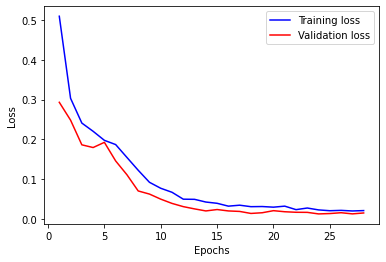

In [ ]:
plot_training_diag(training_history)

## Analysis of the embedding vectors

In [ ]:
test_df = test_df.reset_index()

X_test = []
y_test_mach = []
y_test_soundtype = []

for i in range(test_df.shape[0]):
    path = test_df.loc[i, 'filepath']
    spectro_array = load_spectro(path)
    X_test.append(spectro_array)
    y_test_mach.append(test_df.loc[i, 'machine_num'])
    y_test_soundtype.append(test_df.loc[i, 'sound_type'])
    
X_test = np.array(X_test)
y_test_mach = np.array(y_test_mach)
y_test_soundtype = np.array(y_test_soundtype)

In [ ]:
X_test.shape

(4200, 128, 313, 3)

Calculate the embedding vectors of the test set

In [ ]:
embedded_test = model.predict(X_test)
embedded_test.shape

(4200, 128)

Make 3D PCA instead of 2D PCA

In [ ]:
#Install plotly because interactive plots with %matplotlib notebook does not work with matplotlib
#!pip install plotly

import plotly.express as px


In [ ]:
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap

pca = PCA(n_components = 3)
y_pca = pca.fit_transform(embedded_test)

dict_pca = {'test_soundtype': y_test_soundtype, 'test_machinenum': y_test_mach, 'pca_ax1': y_pca[:,0], 'pca_ax2': y_pca[:,1], 'pca_ax3': y_pca[:,2]}
df_pca = pd.DataFrame.from_dict(dict_pca)

df_pca['test_machine'] = df_pca['test_machinenum'].apply(lambda num: df_machine[df_machine['machine_num']==num].index[0])
#df_pca.head()
#fig = px.scatter_3d(df_pca, x = 'pca_ax1', y = 'pca_ax2', z = 'pca_ax3', color = 'test_machine', symbol = 'test_soundtype')
fig = px.scatter_3d(df_pca, x = 'pca_ax1', y = 'pca_ax2', z = 'pca_ax3', color = 'test_machine')
fig.show()


In [ ]:
df_pca.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4200 entries, 0 to 4199
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   test_soundtype   4200 non-null   int64  
 1   test_machinenum  4200 non-null   int64  
 2   pca_ax1          4200 non-null   float32
 3   pca_ax2          4200 non-null   float32
 4   pca_ax3          4200 non-null   float32
 5   test_machine     4200 non-null   object 
dtypes: float32(3), int64(2), object(1)
memory usage: 147.8+ KB


In [ ]:

df_pca['test_soundtype'] = df_pca['test_soundtype'].astype('string')     # to get discrete colors

machine = 'slider'
fig = px.scatter_3d(df_pca[df_pca['test_machine']==machine], x = 'pca_ax1', y = 'pca_ax2', z = 'pca_ax3', \
                    color = 'test_soundtype', title = machine)
fig.show()




## Supervised classification of the machine type using the embedding vectors
We only try with a Random Forest classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

y_test_both = np.column_stack((y_test_mach, y_test_soundtype))
print(y_test_both.shape)
Xtest_train, Xtest_test, ytest_train, ytest_test = train_test_split(embedded_test, y_test_both, train_size=0.8, random_state=1234)

rfc = RandomForestClassifier()
rfc.fit(Xtest_train, ytest_train[:,0])
print("Train score = ", rfc.score(Xtest_train, ytest_train[:,0]))

pred_machine_proba = rfc.predict_proba(Xtest_test)

(4200, 2)
Train score =  1.0


In [ ]:
y_pred_mach = np.argmax(pred_machine_proba, axis=1) 

y_true_mach = ytest_test[:,0]
y_true_soundtype = ytest_test[:,1]

In [ ]:
print("*** MACHINE = ", machine + " ***")
print(classification_report(y_true_mach, y_pred_mach))
display(pd.crosstab(y_true_mach, y_pred_mach, rownames = ['True'], colnames = ['Pred']))


*** MACHINE =  slider ***
              precision    recall  f1-score   support

           0       0.97      0.94      0.95       112
           1       0.99      0.99      0.99       102
           2       0.97      0.95      0.96       119
           3       0.88      0.86      0.87       129
           4       0.97      0.96      0.96       119
           5       0.89      0.93      0.91       135
           6       0.94      0.98      0.96       124

    accuracy                           0.94       840
   macro avg       0.94      0.94      0.94       840
weighted avg       0.94      0.94      0.94       840



Pred,0,1,2,3,4,5,6
True,,,,,,,
0,105,0,0,7,0,0,0
1,1,101,0,0,0,0,0
2,0,0,113,1,1,3,1
3,2,1,0,111,2,11,2
4,0,0,0,3,114,0,2
5,0,0,3,3,1,125,3
6,0,0,0,1,0,2,121


The machine classification is quite good.

## Deduce the normal/anomalous labels

In [ ]:
def build_result_df(pred_machine_proba, y_true_machine, y_true_soundtype):

    # Reciprocal function of the sigmoid function
    # To spread input x (between 0 and 1) from ~ -11.5 to 13.8
    def inv_sigmoid(x):      # x is a proba between 0 and 1
        if 0.00000001<x and x<0.999999:
            y = np.log(x/(1-x))
        elif x<=0.00000001:
             y = np.log(0.00000001/(1-0.00000001))
        else:
             y = np.log(0.999999/(1-0.999999))
        return y

    y_pred_machine = np.argmax(pred_machine_proba, axis=1) 
    pred_machine_probamax = np.max(pred_machine_proba, axis=1) 
    anomaly_scores = [inv_sigmoid(1 - pred_machine_probamax[i]) for i in range(len(pred_machine_probamax))]
    y_pred_soundtype_proba = 1 - pred_machine_probamax   # proba estimate of being an anomalous sound

    dico = {'anomaly_score': anomaly_scores, 'true_machine': y_true_machine, \
            'pred_machine': y_pred_machine, 'true_soundtype': y_true_soundtype, \
            'pred_soundtype_proba':  y_pred_soundtype_proba, 
            'true_machine_name': [label_encoder.inverse_transform([i])[0] for i in y_true_machine], \
            'pred_machine_name': [label_encoder.inverse_transform([i])[0] for i in y_pred_machine]
            }
    data = pd.DataFrame.from_dict(dico)

    return data


In [ ]:
df_results = build_result_df(pred_machine_proba, y_true_mach, y_true_soundtype)
df_results

,anomaly_score,true_machine,pred_machine,true_soundtype,pred_soundtype_proba,true_machine_name,pred_machine_name
0,-2.197225,4,4,0,0.10,gearbox,gearbox
1,-18.420681,4,4,0,0.00,gearbox,gearbox
2,-18.420681,3,3,0,0.00,fan,fan
3,-0.619039,6,5,1,0.35,valve,slider
4,-4.595120,5,5,0,0.01,slider,slider
...,...,...,...,...,...,...,...
835,-1.734601,6,6,0,0.15,valve,valve
836,-18.420681,1,1,1,0.00,ToyTrain,ToyTrain
837,-0.994623,4,6,1,0.27,gearbox,valve
838,-18.420681,0,0,0,0.00,ToyCar,ToyCar


In [ ]:
def plot_anomaly_scores(df_res):
    fig = plt.figure(figsize = (12, 4))
    ax1 = fig.add_subplot(121)
    g= sns.stripplot(data = df_res, x = 'true_machine_name', y = 'anomaly_score', hue = 'true_soundtype', dodge = True, ax = ax1)
    g.set_xlabel("True machine",fontsize=10)
    g.set_ylabel("Anomaly score",fontsize=10)
    g.tick_params(labelsize=10)
    handles, _ = g.get_legend_handles_labels()
    g.legend(handles, ['normal', 'anormal'], loc = 'lower right', title = 'sound type')

    ax2 = fig.add_subplot(122)
    h = sns.stripplot(data = df_res, x = 'true_machine_name', y = 'anomaly_score', hue = 'pred_machine_name', dodge = True, ax = ax2)
    h.set_xlabel("True machine",fontsize=10)
    h.set_ylabel("Anomaly score",fontsize=10)
    h.tick_params(labelsize=10)
    h.legend(loc = 'lower right', title = 'pred machine')

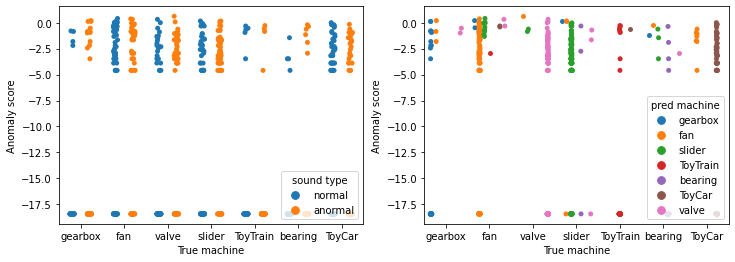

In [ ]:
plot_anomaly_scores(df_results)

In [ ]:
def plot_anomaly_acc_vs_threshold(df_res):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 4))

    for machine in ['valve', 'gearbox', 'fan', 'slider', 'bearing', 'ToyCar', 'ToyTrain']:
        df_res_mach = df_res[df_res['true_machine_name'] == machine].copy()

        # Use a threshold on the anomaly score
        accuracies_1 = []
        score_thresholds = np.linspace(-18.4, 5, 3000)
        for threshold in score_thresholds:
            df_res_mach['pred_soundtype_1'] = df_res_mach['anomaly_score'].apply(lambda score: 1 if score > threshold else 0)
            accuracy = accuracy_score(df_res_mach['true_soundtype'], df_res_mach['pred_soundtype_1'])
            accuracies_1.append(accuracy)

        # Use a threshold on the prediction proba
        accuracies_2 = []
        proba_thresholds = np.linspace(0, 1, 3000)
        for threshold in proba_thresholds:
            df_res_mach['pred_soundtype_2'] = df_res_mach['pred_soundtype_proba'].apply(lambda p: 1 if p > threshold else 0)
            accuracy = accuracy_score(df_res_mach['true_soundtype'], df_res_mach['pred_soundtype_2'])
            accuracies_2.append(accuracy)

        # Plot soundtype accuracies vs threshold for all machines
        ax1.plot(score_thresholds, accuracies_1, label = machine)
        ax2.plot(proba_thresholds, accuracies_2, label = machine)

    ax1.legend()
    ax1.set_xlabel("Anomaly score threshold")
    ax1.set_ylabel("Accuracy")
    ax2.legend()
    ax2.set_xlabel("Probability threshold")
    ax2.set_ylabel("Accuracy")



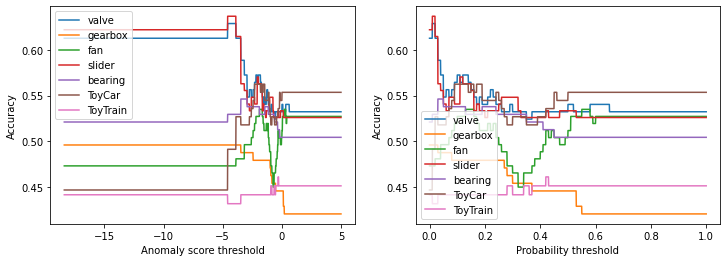

In [ ]:
plot_anomaly_acc_vs_threshold(df_results)

In [ ]:
def compute_AUCs(df_res):
    dict_aucs = {}
    for machine in ['valve', 'gearbox', 'fan', 'slider', 'bearing', 'ToyCar', 'ToyTrain']:
        df_res_mach = df_res[df_res['true_machine_name'] == machine].copy()
        auc = roc_auc_score(df_res_mach['true_soundtype'], df_res_mach['pred_soundtype_proba'])
        dict_aucs[machine] = np.round(auc, 3)

    print(dict_aucs)

    # Plot all machine AUCs
    fig = plt.figure(figsize = (6, 4))
    plt.xticks(range(7), dict_aucs.keys())
    plt.ylabel("AUC")
    plt.grid(True, axis = 'y')
    plt.bar(range(7), dict_aucs.values())

{'valve': 0.609, 'gearbox': 0.556, 'fan': 0.47, 'slider': 0.628, 'bearing': 0.52, 'ToyCar': 0.475, 'ToyTrain': 0.481}


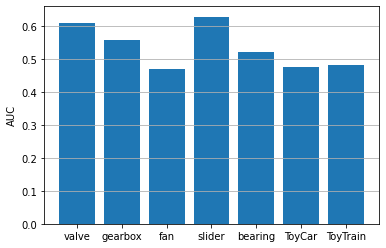

In [ ]:
compute_AUCs(df_results)

## Compare the results with the ones from `ASD_clf_sounds_FaceNet_section.ipynb`

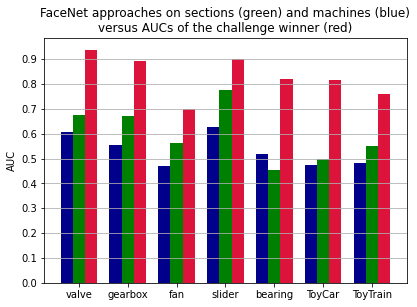

In [ ]:
df_best_auc_DCASE = {'valve': 0.9384, 'gearbox': 0.8928, 'fan': 0.7011, 'slider': 0.9008, \
                     'bearing': 0.8196, 'ToyCar': 0.8150, 'ToyTrain': 0.7622}

df_AUC_FaceNet_machine = {'valve': 0.609, 'gearbox': 0.556, 'fan': 0.47, 'slider': 0.628, \
                          'bearing': 0.52, 'ToyCar': 0.475, 'ToyTrain': 0.481}

df_AUC_FaceNet_section = {'valve': 0.676, 'gearbox': 0.673, 'fan': 0.565, 'slider': 0.778, \
                          'bearing': 0.455, 'ToyCar': 0.499, 'ToyTrain': 0.551}    



fig = plt.figure(figsize = (6.5, 4.5))
plt.xticks([i + 0.25 for i in range(7)], df_best_auc_DCASE.keys())
plt.yticks([0.1*i for i in range(10)])
plt.ylabel("AUC")
plt.grid(True, axis = 'y')

plt.bar(range(7), df_AUC_FaceNet_machine.values(), color = 'darkblue', width = 0.25)
plt.bar([i + 0.25 for i in range(7)], df_AUC_FaceNet_section.values(), color ='g', width = 0.25)
plt.bar([i + 0.5 for i in range(7)], df_best_auc_DCASE.values(), color ='crimson', width = 0.25)

plt.title("FaceNet approaches on sections (green) and machines (blue)\nversus AUCs of the challenge winner (red)");